# Point Regression Using CNN with Head Pose Dataset

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from fastai.vision import get_image_files, open_image, open_mask, URLs, untar_data
from fastai.vision import get_transforms, error_rate, lr_find, cnn_learner, defaults, imagenet_stats, tensor, plot_multi
from fastai.vision import models as vision_models
from fastai.vision import PointsItemList, ImagePoints, FlowField
from fastai.utils.mem import gpu_mem_get_free_no_cache

### Unloading data to OS default path

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/22.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/08.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/17'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/17.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/21.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/03'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/05.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/12'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/14'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/05'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/07.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/21'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/23.obj'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/23'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/22'),
 PosixPath('/home/ubuntu/.fastai/data/biwi_head_pose/16.obj'),
 PosixPath('/home/ubuntu

In [3]:
# code as is

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [4]:
fname = '09/frame_00667_rgb.jpg'

In [5]:
# code as is

def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

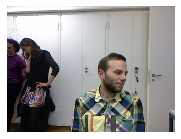

In [6]:
img = open_image(path/fname)
img.show()

In [7]:
# code as is

ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [8]:
# code as is

def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [9]:
ctr = get_ctr(fname)
ctr

tensor([263.9104, 428.5814])

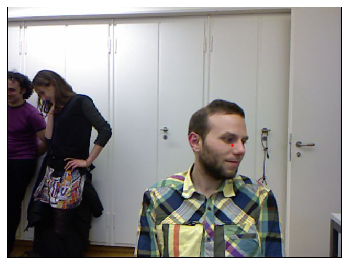

In [10]:
img.show(y=get_ip(img, ctr), figsize=(6, 6))

### Creating a dataset

In [11]:
# code as is

dataset = (PointsItemList.from_folder(path).split_by_valid_func(lambda o: o.parent.name=='13').label_from_func(get_ctr).transform(get_transforms(), tfm_y=True, size=(120,160)).databunch().normalize(imagenet_stats))

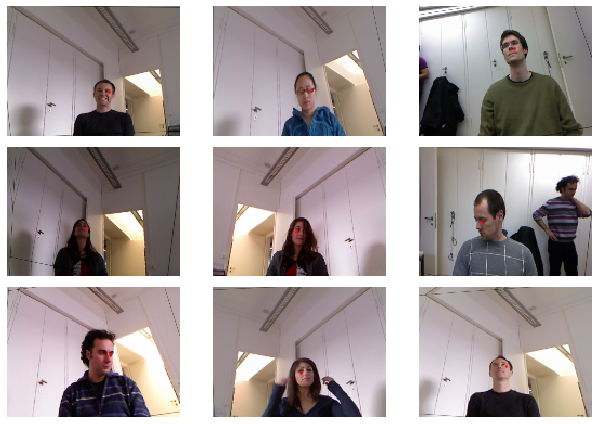

In [12]:
dataset.show_batch(3, figsize=(9,6))

### Modelling

In [13]:
learn = cnn_learner(dataset, vision_models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 6.92E-03


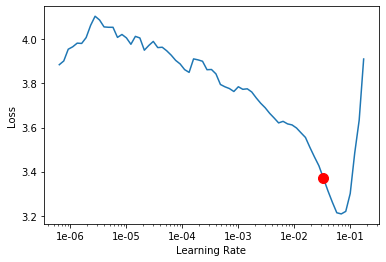

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
lr = 3.31E-02

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.165756,0.037634,01:54
1,0.023954,0.009757,01:54
2,0.010352,0.008864,01:55
3,0.006374,0.002461,01:54
4,0.004949,0.002110,01:55


### More on Data Augumentation

In [18]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

dataset = (PointsItemList.from_folder(path).split_by_valid_func(lambda o: o.parent.name=='13').label_from_func(get_ctr).transform(tfms, tfm_y=True, size=(120,160)).databunch().normalize(imagenet_stats))

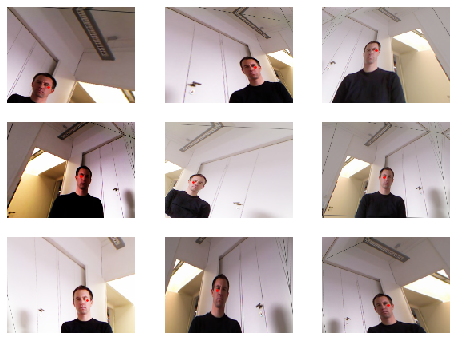

In [21]:
def _plot(i, j, ax):
    x, y = dataset.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8, 6))